#Algoritimo Genético MultiObjetivo para Imputação Múltipla de Dados Aplicado na Classificação Multirrótulo 

#Importações


In [151]:
import numpy as np
import scipy as sp
import future as ft
import sklearn
from scipy.io import arff
import pandas as pd

#instalações
!pip install scikit-multilearn
!pip install liac-arff # for loading ARFF files
!pip install iterative-stratification 
!pip install missingpy


#importações poś-intalações
from skmultilearn.dataset import load_dataset
import arff


#Lendo datasets originais do Repositório Mulan





In [152]:
def load_dataset(dataset_name):
  from skmultilearn.dataset import load_dataset
  X,y,feature_names, label_names = load_dataset(dataset_name, 'undivided')
  return X.toarray(),y.toarray(),feature_names, label_names

In [153]:
##ordem dos dados (X,y,features e labels)
data = load_dataset('emotions')

emotions:undivided - exists, not redownloading


In [154]:
X = data[2]
X

[('Mean_Acc1298_Mean_Mem40_Centroid', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Rolloff', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Flux', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_0', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_1', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_2', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_3', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_4', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_5', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_6', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_7', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_8', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_9', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_10', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_11', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_12', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_Centroid', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_Rolloff', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_Flux', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_MFCC_0', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_MFCC_1', 'NUM

In [155]:
def counter(y):
  from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
  from collections import Counter
  distribuicao_labels = Counter(combination for row in get_combination_wise_output_matrix(y, order=1) for combination in row)
  return distribuicao_labels


In [156]:
#counter(data[1])




## Aplicando Validação Cruzada k-fold 
Testes iniciais com 10-folds

In [157]:
#X,y in numpy format
def cross_validation(X,y,num_folds, randon_state=0):
  from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
  mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)
  for train_index, test_index in mskf.split(X, y):
   #print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
  return X_train, X_test, y_train, y_test

In [158]:
data_train_and_test = cross_validation(data[0], data[1],10)

In [159]:
X_train = data_train_and_test[0]
X_test = data_train_and_test[1]
y_train = data_train_and_test[2]
y_test = data_train_and_test[3]

#Exibindo informações do dataset trabalhado

In [160]:
#verificando a presença de valores ausentes
def missing_values(df):
  amount = (df.isna().sum()).sum()
  return amount



In [161]:
valores_ausentes = missing_values(pd.DataFrame(X_train))
valores_ausentes

0

In [162]:
#padronização Dataset de teste
#X in numpy format
def padronizacao(X):
  from sklearn.preprocessing import StandardScaler
  scl = StandardScaler()
  X_scaler = scl.fit_transform(X)
  return X_scaler



In [163]:
X_test_scaler = padronizacao(X_test)
X_test_scaler

array([[-0.52751657, -0.7163883 ,  1.21315006, ..., -0.04586578,
        -0.22651953, -0.60392646],
       [-0.15986713, -0.37935696, -0.83883174, ...,  1.14280483,
         0.3797663 ,  0.38762244],
       [ 2.04640878,  1.25442176,  1.24451415, ..., -1.00563697,
        -0.19717983, -0.87608304],
       ...,
       [-0.96235614, -1.02193939, -0.6029958 , ..., -0.76221794,
        -0.88382307, -0.78601863],
       [ 1.4356929 ,  0.61769484,  1.20874808, ...,  0.29080106,
         1.34725769,  0.49765303],
       [-0.89368062, -1.08026503, -0.36782015, ..., -0.88947997,
         0.12370162, -0.67435006]])

#Amputando dataset

*   Mecanismo VA: MCAR



Quantificando os percentuais de valores ausentes de acordo com cada database

In [164]:
#retorna um lista com as posições com Valores ausentes e o dataset amputado
def amputation(rate, X):
  from numpy import random

  amount_missing_values = int(X.size * rate)
  print('Total dados: '+str(X.size)+'\n Total VAs: '+str(amount_missing_values)+'\n')

  rows = X.shape[0]
  cols = X.shape[1]
  index_list = []
  df = pd.DataFrame(X)

  while(len(index_list)<amount_missing_values):
    a = 0
    b = 0
    row = random.randint(0,rows)
    col = random.randint(0,cols)
    if(a != row and b != col):
      a = row
      b = col
      df.iloc[row,col] = np.nan
      index_list.append([row,col])
  return df, index_list

In [165]:
a = amputation(0.25, X_train)


Total dados: 38160
 Total VAs: 9540



In [166]:
a[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,0.672063,0.783788,0.766640,0.458712,0.530384,0.812429,0.028851,0.129039,0.039614,5.762173,1.636819,1.170034,1.051511,0.764163,0.642705,0.617868,0.510265,0.566213,0.509149,0.477275,0.505073,0.463535,0.013519,0.050591,0.009025,8.156257,1.077167,0.624711,0.810244,0.399568,0.279947,0.314215,0.231439,0.345401,0.285389,0.210613,0.321896,0.290551,0.022774,0.095801,0.015057,4.748694,0.536378,0.296306,0.273210,0.175800,0.105508,0.168246,0.115849,0.136020,0.110514,0.100517,0.118630,0.094923,0.051035,68.0,0.014937,136.0,2.0,0.245457,0.105065,0.405399
1,0.081374,0.272747,NaN,-62.584437,3.183163,-0.218145,0.163038,0.620251,NaN,0.041426,0.308287,0.538152,0.594871,0.734332,NaN,NaN,0.066288,NaN,0.034438,3.480874,1.596532,0.943803,0.804444,0.511229,NaN,0.523039,0.480916,NaN,0.483166,0.445187,0.415994,NaN,0.013621,0.073041,0.010094,NaN,0.829790,0.252972,NaN,0.205087,0.168601,0.178009,0.144080,0.178703,0.146937,0.125580,0.128202,0.107007,NaN,NaN,0.029483,NaN,NaN,0.168389,NaN,0.098341,0.087046,0.057991,NaN,0.059457,0.053439,0.067684,0.070075,0.041565,0.295031,70.0,NaN,140.0,2.0,NaN,0.276366,0.710924
2,0.110545,NaN,NaN,-65.235325,2.794964,0.639047,NaN,0.757896,NaN,0.627636,0.469322,0.644336,0.441556,NaN,0.290713,0.158538,NaN,0.215373,0.035970,NaN,1.213443,0.864034,0.909222,NaN,0.550833,0.639740,0.573309,0.526312,NaN,0.538407,0.492292,0.455562,NaN,0.070433,0.008525,2.759906,0.592634,0.761852,0.568740,0.589827,NaN,0.437752,NaN,0.227320,0.296224,0.273855,NaN,NaN,0.038119,NaN,NaN,3.371796,0.430373,NaN,NaN,0.184333,0.095718,0.139323,0.109279,0.090650,NaN,0.100852,0.079917,0.085821,0.161574,NaN,0.000000,183.0,3.0,0.188693,NaN,0.457372
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,NaN,0.809644,0.460945,0.409566,NaN,0.590405,NaN,NaN,0.049939,NaN,0.044727,6.719538,1.377811,NaN,0.986178,0.710955,0.706904,NaN,0.688825,NaN,0.577976,0.533882,0.501818,0.495368,NaN,0.106318,0.009108,3.992357,0.656429,0.927692,0.569916,0.378919,0.530714,0.317807,0.308447,0.324934,0.263444,0.359477,0.274257,0.233287,NaN,0.119480,0.028707,4.125111,NaN,0.280751,NaN,NaN,NaN,0.124399,0.155513,0.167114,0.113774,0.112815,0.129145,0.122330,0.043012,NaN,0.206562,NaN,2.0,0.102839,NaN,0.351009
4,0.074550,NaN,0.079789,NaN,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,0.796904,NaN,NaN,0.594429,0.454186,0.384836,0.035751,0.085592,0.029413,4.755293,1.116290,NaN,0.634988,0.639660,0.552653,NaN,0.584705,NaN,0.648611,0.689096,0.643595,NaN,0.047014,NaN,NaN,NaN,1.592642,1.027190,0.591399,0.565654,0.524420,0.554501,0.606200,0.616760,0.596926,0.524291,0.637971,0.637960,0.036151,0.087741,0.030180,5.085385,0.551937,0.257562,0.159950,0.175855,0.150907,0.142092,0.222804,0.329188,0.251668,0.265049,0.284196,0.189988,NaN,NaN,0.144039,NaN,2.0,NaN,0.310801,0.683817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.027142,0.047551,0.072043,-79.881347,8.119313,1.927310,1.696017,0.397888,0.857559,0.302742,NaN,0.748163,0.412952,NaN,NaN,NaN,0.013099,0.029163,NaN,3.076905,0.862406,0.640101,NaN,NaN,0.514684,0.577850,0.600797,0.544352,NaN,0.553717,0.493653,NaN,NaN,0.044107,0.008805,2.560837,NaN,0.523135,0.802130,0.694118,0.412457,0.461475,NaN,NaN,0.454346,0.437815,0.345676,0.366906,NaN,0.069883,0.030413,5.042254,NaN,0.177015,0.165939,0.124718,NaN,NaN,0.146845,0.139167,NaN,NaN,0.129552,0.106260,0.089991,87.0,0.564842,174.0,2.0,0.261742,0.002657,1.149211
526,0.094829,0.204498,NaN,NaN,2.966229,NaN,NaN,0.856243,1.110282,0.394450,0.726323,NaN,0.517

In [167]:
total_nan = (a[0].isnull().sum()).sum()
total_nan

8423

In [168]:
def grafic_bar_missing_values(df):
  import missingno as msno
  msno.bar(df)

In [169]:
def grafic_matrix_missing_values(df):
  import missingno as msno
  msno.matrix(df)

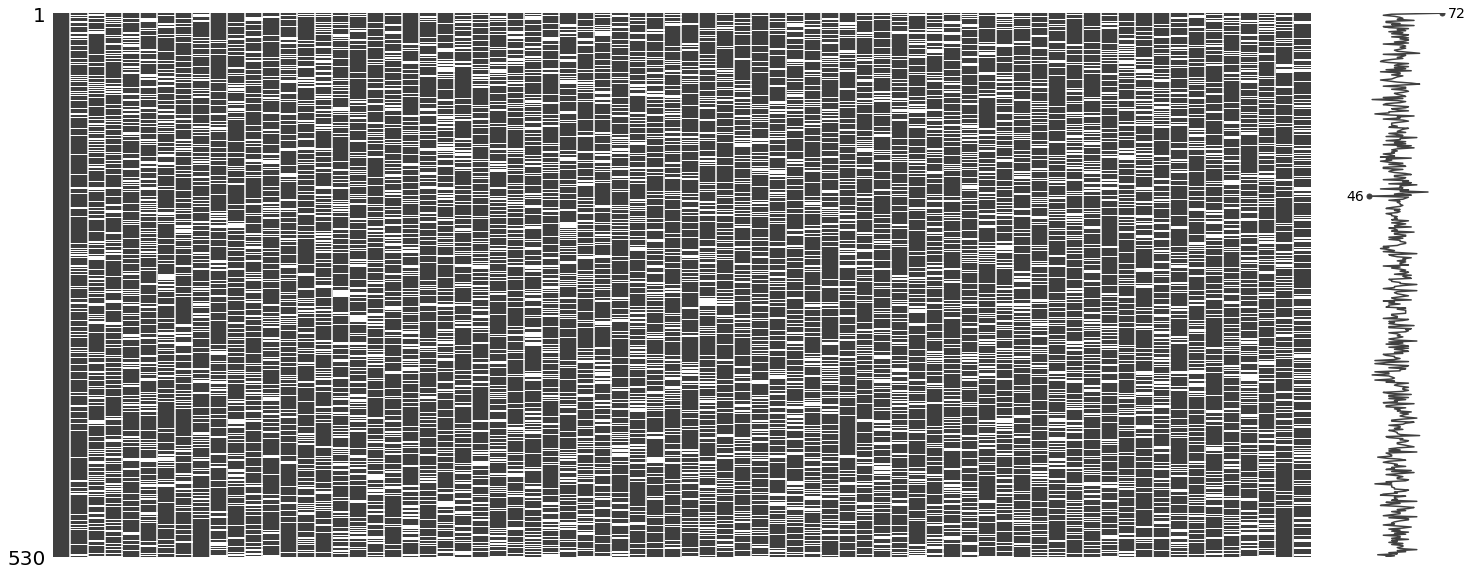

In [170]:
grafic_matrix_missing_values(pd.DataFrame(a[0]))

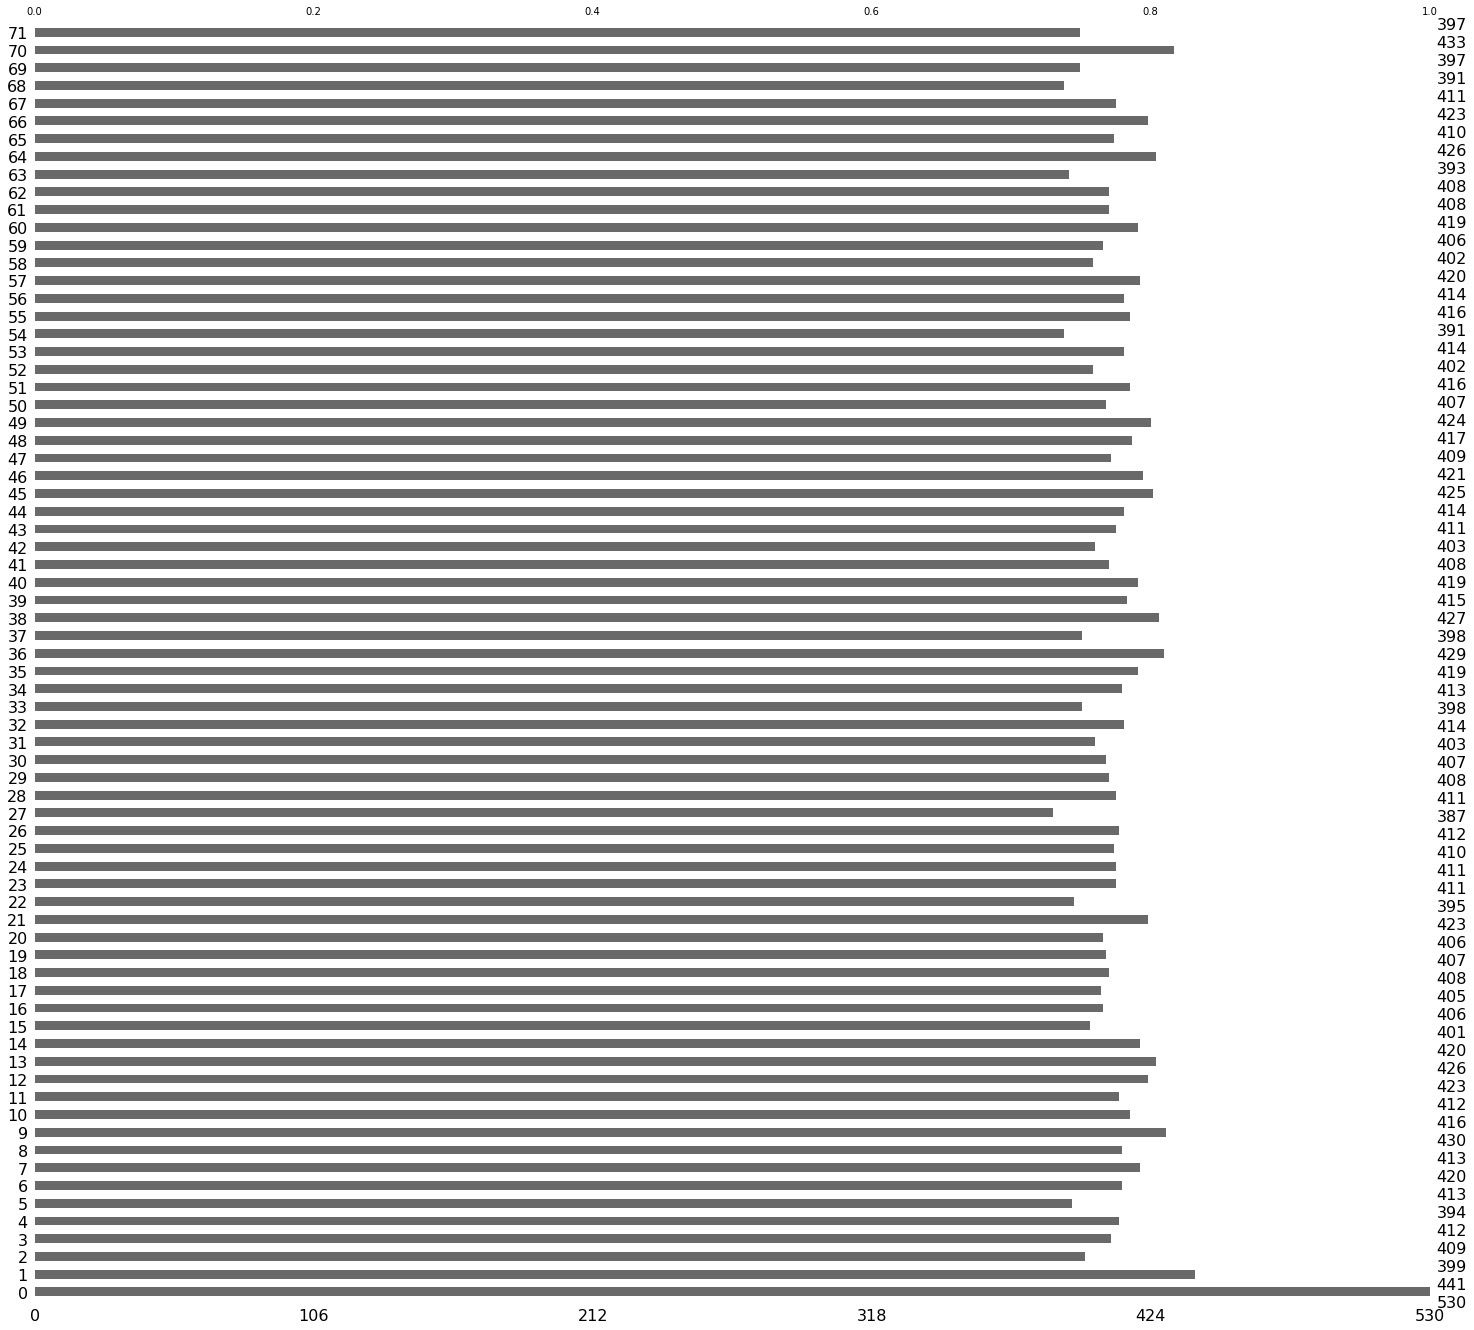

In [171]:
grafic_bar_missing_values(pd.DataFrame(a[0]))

In [172]:
def grafic_line_missing_values(df):
  import matplotlib.pyplot as plt 
  plt.figure(figsize=(20,3))
  plt.plot(df.isnull().sum(),marker='o')
  plt.title("Distribuição de Missing Values por features")
  plt.show()

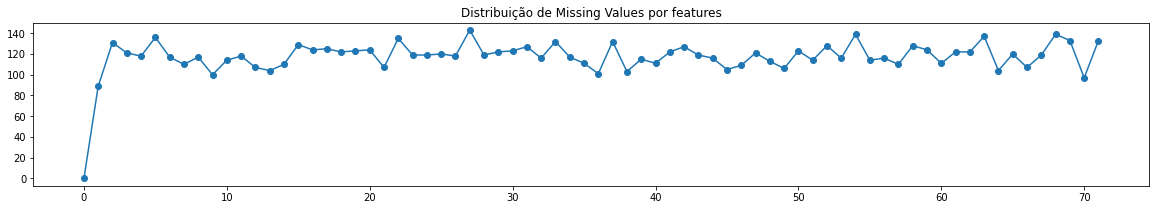

In [173]:
grafic_line_missing_values(pd.DataFrame(a[0]))

In [174]:
def describe(df):
  return df.describe()

In [175]:
describe(pd.DataFrame(data[0]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.069309,0.195399,0.085695,-72.998228,4.979178,0.602395,1.694625,0.634156,0.833964,0.508060,0.539452,0.471183,0.509122,0.477661,0.439237,0.445350,0.045755,0.157495,0.035775,4.574782,1.298807,0.941415,0.778116,0.650144,0.577431,0.552497,0.536358,0.518485,0.509343,0.492222,0.483663,0.469662,0.023932,0.063271,0.008137,3.641956,0.858002,0.623887,0.499193,0.385509,0.331884,0.313391,0.307803,0.304763,0.298987,0.287374,0.279034,0.271922,0.028901,0.066452,0.029527,4.147196,0.408222,0.239404,0.198588,0.151062,0.123111,0.115476,0.114181,0.113154,0.113794,0.109990,0.109876,0.107114,0.230008,74.456998,0.247854,155.215852,2.099494,0.412940,0.354901,0.959906
std,0.031293,0.117605,0.009260,7.580804,2.071792,1.017603,0.606581,0.448746,0.368312,0.303277,0.304705,0.282673,0.244190,0.219967,0.221101,0.201583,0.029710,0.108850,0.008561,1.560977,0.403095,0.270601,0.213410,0.154363,0.107429,0.094156,0.090469,0.083432,0.081292,0.072786,0.074544,0.077775,0.010763,0.031272,0.001489,1.807698,0.369745,0.258519,0.205131,0.152623,0.136194,0.138493,0.145385,0.158808,0.153431,0.162264,0.154762,0.163367,0.007393,0.023734,0.001404,0.509198,0.135642,0.086144,0.079094,0.060607,0.041531,0.038110,0.038317,0.044755,0.047745,0.049567,0.053819,0.059361,0.295863,14.610203,0.366541,29.807954,0.316040,0.339559,0.362262,0.651827
min,0.010201,0.038286,0.070932,-99.090802,0.051474,-2.277307,-0.604609,-1.143864,-0.237114,-0.444623,-0.895966,-0.451919,-0.294770,-0.258025,-0.394065,-0.129515,0.006918,0.017434,0.025297,1.665689,0.544490,0.426085,0.436355,0.343973,0.376085,0.329479,0.322254,0.327975,0.296855,0.297832,0.281625,0.273264,0.010574,0.018333,0.005696,1.103874,0.181559,0.107836,0.079273,0.055489,0.040192,0.048815,0.068473,0.055301,0.057608,0.048231,0.041973,0.033739,0.008712,0.015678,0.009090,1.908520,0.105014,0.048375,0.052660,0.034480,0.039299,0.024210,0.036153,0.032399,0.035843,0.038015,0.032472,0.031945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044781,0.107742,0.079018,-77.078349,3.409922,-0.113441,1.307242,0.373195,0.605057,0.309033,0.361401,0.293853,0.356008,0.348202,0.306319,0.310737,0.023090,0.064634,0.030011,3.480119,1.004433,0.729514,0.595706,0.531264,0.494993,0.483637,0.471581,0.455864,0.452901,0.439741,0.430855,0.418312,0.017352,0.042342,0.007328,2.379514,0.611524,0.437861,0.361387,0.282277,0.242179,0.221745,0.211859,0.203123,0.195383,0.184146,0.182069,0.174657,0.024807,0.051708,0.029041,3.760212,0.310948,0.173113,0.137808,0.103660,0.092296,0.087538,0.087673,0.082425,0.081609,0.077882,0.075211,0.071286,0.047611,64.000000,0.007556,132.000000,2.000000,0.179411,0.099424,0.513974
50%,0.065251,0.169757,0.083637,-72.474302,4.642338,0.588380,1.731031,0.618838,0.819652,0.534665,0.520869,0.463832,0.500074,0.486893,0.435266,0.449567,0.037587,0.124873,0.033947,4.449266,1.266361,0.928566,0.735529,0.625212,0.557059,0.541025,0.523278,0.513161,0.501205,0.484658,0.478762,0.462062,0.021436,0.054313,0.007871,3.253290,0.779757,0.582761,0.471871,0.3

In [176]:
#Instalando o panda profile
#!pip install pandas-profiling
#from pandas_profiling import ProfileReport

#Imputação de dados


*   k-Nearest Neighbors (kNN) Imputation
*   mean
*   most_frequent
*   median







# Criação da popoulação inicial

imputando os indivíduos

In [177]:
#def knnImp(dataset_amputed):
#  from missingpy import KNNImputer
#  imputer_knn = KNNImputer(missing_values="NaN", n_neighbors=5, weights="uniform", 
#                 metric="masked_euclidean", row_max_missing=0.5, 
#                 col_max_missing=0.8, copy=True)
  
  #X_imputed_KNNI = imputer_knn.fit_transform(dataset_amputed)
  #return X_imputed_KNNI

In [178]:
from sklearn.impute import KNNImputer
def knnImp(dataset_amputed,neighbors):
  inputer_knn = KNNImputer(n_neighbors=neighbors)
  X_imputed_knn = inputer_knn.fit_transform(dataset_amputed)
  return X_imputed_knn

In [179]:
def rfImp(dataset_amputed):
  from missingpy import MissForest
  imputer_RFI = MissForest()
  X_imputed_RFI = imputer_RFI.fit_transform(dataset_amputed)
  return X_imputed_RFI

In [180]:
def meanImp(dataset_amputed):
  from sklearn.impute import SimpleImputer
  imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  imputer_mean=imputer_mean.fit(dataset_amputed)
  X_imputed_mean = imputer_mean.transform(dataset_amputed)
  return X_imputed_mean

In [181]:
def mostFrequentImp(dataset_amputed):
  from sklearn.impute import SimpleImputer
  imputer_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  imputer_most_frequent=imputer_most_frequent.fit(dataset_amputed)
  X_imputed_most_frequent=imputer_most_frequent.transform(dataset_amputed)
  return X_imputed_most_frequent

In [182]:
def medianImp(dataset_amputed):
  from sklearn.impute import SimpleImputer
  imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
  imputer_median=imputer_median.fit(dataset_amputed)
  X_imputed_median=imputer_median.transform(dataset_amputed)
  return X_imputed_median

In [183]:
def imputation(method, df):
  #import gerais
  import sklearn.neighbors._base
  import sys
  sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
  

  if method == 'mean':
    base_imputada = meanImp(df)
  elif method == 'median':
    base_imputada = medianImp(df)
  elif method == 'most_frequent':
    base_imputada = mostFrequentImp(df)
  elif method == 'knn-3':
    base_imputada = knnImp(df,3)
  elif method == 'knn-5':
    base_imputada = knnImp(df,5)
  elif method == 'knn-10':
    base_imputada = knnImp(df,10)
  return base_imputada


Padronização dos dados

In [184]:
imputation_meth  = ['knn-3','knn-5','knn-10', 'mean', 'most_frequent', 'median']
inds = []
df_amp = pd.DataFrame(a[0])
for i  in imputation_meth:
  inds.append(imputation(i,df_amp))

In [185]:
inds

[array([[0.034741  , 0.089665  , 0.091225  , ..., 0.245457  , 0.105065  ,
         0.405399  ],
        [0.081374  , 0.272747  , 0.09121667, ..., 0.54688067, 0.276366  ,
         0.710924  ],
        [0.110545  , 0.20073667, 0.08534833, ..., 0.188693  , 0.106065  ,
         0.457372  ],
        ...,
        [0.035169  , 0.09657067, 0.075227  , ..., 0.184313  , 0.247136  ,
         0.338665  ],
        [0.054276  , 0.26828267, 0.095935  , ..., 0.74200067, 0.183494  ,
         1.48149667],
        [0.073194  , 0.140733  , 0.07804767, ..., 0.332889  , 0.236815  ,
         0.451701  ]]),
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0894922, ..., 0.768412 , 0.276366 ,
         0.710924 ],
        [0.110545 , 0.2034182, 0.0833432, ..., 0.188693 , 0.1841766,
         0.457372 ],
        ...,
        [0.035169 , 0.0888612, 0.075227 , ..., 0.184313 , 0.247136 ,
         0.465628 ],
        [0.054276 , 0.229107 , 0.095

In [186]:
len(inds)

6

Normmalização da população inicial

In [187]:
populationInitial = inds
#for i in range(len(individuos)):
#  populationInitial.append(padronizacao(individuos[i]))

In [188]:
populationInitial

[array([[0.034741  , 0.089665  , 0.091225  , ..., 0.245457  , 0.105065  ,
         0.405399  ],
        [0.081374  , 0.272747  , 0.09121667, ..., 0.54688067, 0.276366  ,
         0.710924  ],
        [0.110545  , 0.20073667, 0.08534833, ..., 0.188693  , 0.106065  ,
         0.457372  ],
        ...,
        [0.035169  , 0.09657067, 0.075227  , ..., 0.184313  , 0.247136  ,
         0.338665  ],
        [0.054276  , 0.26828267, 0.095935  , ..., 0.74200067, 0.183494  ,
         1.48149667],
        [0.073194  , 0.140733  , 0.07804767, ..., 0.332889  , 0.236815  ,
         0.451701  ]]),
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0894922, ..., 0.768412 , 0.276366 ,
         0.710924 ],
        [0.110545 , 0.2034182, 0.0833432, ..., 0.188693 , 0.1841766,
         0.457372 ],
        ...,
        [0.035169 , 0.0888612, 0.075227 , ..., 0.184313 , 0.247136 ,
         0.465628 ],
        [0.054276 , 0.229107 , 0.095

In [189]:
inds[0].shape, populationInitial[0].shape

((530, 72), (530, 72))

In [190]:
X_train.shape, y_train.shape

((530, 72), (530, 6))

# Função Fitness

Os indivíduos da população são avaliados no aprendizado multirrótulo.
Neste experimento, serão testados algorítmos que transformam o problema e algorítmos que adaptam o problema.

In [191]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def evaluation_binaryRelevance(core_algorithm, individual, metric = 'F1'):
  if core_algorithm == 'svm':
    classifier_br = BinaryRelevance(classifier=SVC(C=50),require_dense=[False, True])#
    classifier_br.fit(individual, y_train)
    prediction_br = classifier_br.predict(X_test)

    F1 = f1_score(y_test, prediction_br, average='micro')
    ACC = accuracy_score(y_test, prediction_br)
    HL = hamming_loss(y_test, prediction_br)

  elif core_algorithm == 'randomForest':
    classifier = BinaryRelevance(classifier = RandomForestClassifier(),require_dense = [False, True])
    classifier.fit(individual, y_train)
    prediction_br_RFC=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_RFC, average='micro')
    ACC = accuracy_score(y_test, prediction_br_RFC)
    HL = hamming_loss(y_test, prediction_br_RFC)
  elif core_algorithm == '3nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=3))
    classifier.fit(individual, y_train)
    prediction_br_3knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_3knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_3knn)
    HL = hamming_loss(y_test, prediction_br_3knn)
  elif core_algorithm == '5nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier())
    classifier.fit(individual, y_train)
    prediction_br_5knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_5knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_5knn)
    HL = hamming_loss(y_test, prediction_br_5knn)
  elif core_algorithm == '10nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=10))
    classifier.fit(individual, y_train)
    prediction_br_10knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_10knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_10knn)
    HL = hamming_loss(y_test, prediction_br_10knn) 
  elif core_algorithm == 'lr':
    from sklearn.linear_model import LogisticRegression
    classifier = BinaryRelevance(classifier = LogisticRegression())
    classifier.fit(individual, y_train)
    prediction_br_lr=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_lr, average='micro')
    ACC = accuracy_score(y_test, prediction_br_lr)
    HL = hamming_loss(y_test, prediction_br_lr)
  if metric == 'ACC':
    return  ACC
  elif metric == 'F1':
    return F1
  elif metric == 'HL':
    return HL


In [192]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def evaluation_BinaryRelevance(core_algorithm, individual):
  p = []
  if core_algorithm == 'svm':
    classifier_br = BinaryRelevance(classifier=SVC(C=50),require_dense=[False, True])#
    classifier_br.fit(individual, y_train)
    prediction_br = classifier_br.predict(X_test)

    F1 = f1_score(y_test, prediction_br, average='micro')
    ACC = accuracy_score(y_test, prediction_br)
    HL = hamming_loss(y_test, prediction_br)

  elif core_algorithm == 'randomForest':
    classifier = BinaryRelevance(classifier = RandomForestClassifier(),require_dense = [False, True])
    classifier.fit(individual, y_train)
    prediction_br_RFC=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_RFC, average='micro')
    ACC = accuracy_score(y_test, prediction_br_RFC)
    HL = hamming_loss(y_test, prediction_br_RFC)
  elif core_algorithm == '3nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=3))
    classifier.fit(individual, y_train)
    prediction_br_3knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_3knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_3knn)
    HL = hamming_loss(y_test, prediction_br_3knn)
  elif core_algorithm == '5nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier())
    classifier.fit(individual, y_train)
    prediction_br_5knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_5knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_5knn)
    HL = hamming_loss(y_test, prediction_br_5knn)
  elif core_algorithm == '10nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=10))
    classifier.fit(individual, y_train)
    prediction_br_10knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_10knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_10knn)
    HL = hamming_loss(y_test, prediction_br_10knn) 
  elif core_algorithm == 'lr':
    from sklearn.linear_model import LogisticRegression
    classifier = BinaryRelevance(classifier = LogisticRegression())
    classifier.fit(individual, y_train)
    prediction_br_lr=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_lr, average='micro')
    ACC = accuracy_score(y_test, prediction_br_lr)
    HL = hamming_loss(y_test, prediction_br_lr)
  return ACC,F1,HL

In [193]:
#svm = evaluation_binaryRelevance('svm', populationInitial[0])
#knn3 = evaluation_binaryRelevance('3nn', populationInitial[0])
#knn5 = evaluation_binaryRelevance('5nn', populationInitial[0])
#knn10 = evaluation_binaryRelevance('10nn', populationInitial[0])
#rf = evaluation_binaryRelevance('randomForest', populationInitial[0])


In [194]:
#print(svm, knn3, knn5,knn10, rf)

Não executando Random Forest devido também ser um algorítmo que funciona como bagging

In [195]:
def fitness(population,metric):
  metrica = []
  populacao = []
  aval_lista_descrecente = []
  aval_lista_crescente = []
  indivuduos = {}
  accuracy = {}
  print('tam_pop_atual: ',len(population))
  print('Avaliações com Binary Relevance\n')
  indexx = 0
  for i in range(len(population)):
    print('Individual - ',i)
    metrica.append(evaluation_binaryRelevance('svm', population[indexx], metric=metric))
    metrica.append(evaluation_binaryRelevance('randomForest', population[indexx],metric=metric))
    metrica.append(evaluation_binaryRelevance('3nn', population[indexx],metric=metric))
    metrica.append(evaluation_binaryRelevance('5nn', population[indexx],metric=metric))
    metrica.append(evaluation_binaryRelevance('10nn', population[indexx],metric=metric))

    aval_lista_descrecente = sorted(metrica, reverse=True)
    aval_lista_crescente = sorted(metrica)

    melhor = aval_lista_descrecente[0]
    pior = aval_lista_crescente[0]

    populacao.append([melhor, population[indexx]])

    indivuduos[i] = melhor
    indexx = indexx+1
    print('Pior:', pior, ' melhor (escolhido):', melhor)
    print('----------------------------------------------------')
    melhor = ''
    pior = ''
    aval_lista_descrecente = []
    aval_lista_crescente = []
    metrica = []
  return populacao



In [221]:
def fitness_multi(population,base_algoritmo):
  metrica = []
  bests = []
  aval_total_ind = []
  populacao = []
  sort_dsc=[]
  sort_asc=[]
  indivuduos = {}
  accuracy = {}
  #print('tam_pop_atual: ',len(population))
  print('Avaliações com Binary Relevance\n')
  indexx = 0
  for i in range(len(population)):
    #print('Individual - ',i)
    a,f,h = evaluation_BinaryRelevance(base_algoritmo, population[indexx])
    print('ind:['+str(i)+'] - '+str(a)+' '+ str(f)+' '+str(h)+' ['+str(a+f-h)+']' )
    
    #realizando o calculo multiobjetivo: sum = acc+f1-hl
    sum = a+f-h
    metrica.append([sum,a,f,h])

    #sort_dsc = sorted(metrica, reverse=True)
    #sort_asc = sorted(metrica)
    #print(sort)
    #melhor = sort_dsc[0]
    #pior = sort_asc[0]
    #print(str(melhor))
    #print(str(pior))
    populacao.append([[sum,a,f,h], population[indexx]])
    indexx = indexx+1
    #aval_total_ind.append(sum)
    #metrica = []
    sort_dsc=[]
    sort_asc=[]
    melhor =''
    pior=''
  return sorted(populacao, key=lambda x: x[0][0], reverse=True)#sorted(populacao,reverse=True)

In [197]:
r = fitness_multi(populationInitial,'svm')

Avaliações com Binary Relevance

ind:[0] - 0.20634920634920634 0.5081081081081081 0.24074074074074073
ind:[1] - 0.20634920634920634 0.5081081081081081 0.24074074074074073
ind:[2] - 0.2222222222222222 0.5108695652173912 0.23809523809523808
ind:[3] - 0.2222222222222222 0.5027932960893855 0.23544973544973544
ind:[4] - 0.07936507936507936 0.4025974025974026 0.24338624338624337
ind:[5] - 0.2222222222222222 0.5139664804469274 0.23015873015873015


In [198]:
r[1]

[[0.49499654934437537,
  0.2222222222222222,
  0.5108695652173912,
  0.23809523809523808],
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0887934, ..., 0.6233254, 0.276366 ,
         0.710924 ],
        [0.110545 , 0.2115871, 0.0860223, ..., 0.188693 , 0.1534682,
         0.457372 ],
        ...,
        [0.035169 , 0.103277 , 0.075227 , ..., 0.184313 , 0.247136 ,
         0.682225 ],
        [0.054276 , 0.2438327, 0.095935 , ..., 0.6562328, 0.183494 ,
         1.0499564],
        [0.073194 , 0.140733 , 0.0797822, ..., 0.23088  , 0.236815 ,
         0.451701 ]])]

In [199]:
len(r)

6

In [200]:
for i in r:
  print(i[0][0])

0.5060299725104195
0.49499654934437537
0.48956578286187225
0.47371657371657383
0.47371657371657383
0.2385762385762386


In [201]:
#populacao_inicial_avaliada = fitness(populationInitial,'ACC')

In [202]:
#populacao_inicial_avaliada

# Elitismo
O melhor individuo é passado para a proxima geracao - Elitismo

In [203]:
#def elitismo(populacao_avaliada):
#  #ordena a população passada de forma descrescente
#  populacao_ordenada  = sorted(populacao_avaliada, key=lambda x: x[0], reverse=True)
#  elitista = populacao_ordenada[0]
#  return elitista

In [204]:
#elitista = elitismo(populacao_inicial_avaliada)

In [205]:
#elitista

# Seleção

O processo de seleçãp é dado por torneio, sorteando dois pais

In [206]:
import random
def selecao(pop_atual):
  sorteio1 = random.choice(range(len(pop_atual)))
  #print(sorteio1)
  sorteio2 = random.choice(range(len(pop_atual)))
  #print(sorteio2)
  pai1 = pop_atual[sorteio1]
  pai2 = pop_atual[sorteio2]
  #print('pai 1')
  #print(pai1)
  #print('pai 2')
  #print(pai2)
  #print('pai 2[0]')
  #print(pai2[0][0])
  #print('fimpai 2')
  if(pai1[0][0] >= pai2[0][0]):
    return pai1
  else:
    return pai2

In [207]:
selecao(r)

[[0.47371657371657383,
  0.20634920634920634,
  0.5081081081081081,
  0.24074074074074073],
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0894922, ..., 0.768412 , 0.276366 ,
         0.710924 ],
        [0.110545 , 0.2034182, 0.0833432, ..., 0.188693 , 0.1841766,
         0.457372 ],
        ...,
        [0.035169 , 0.0888612, 0.075227 , ..., 0.184313 , 0.247136 ,
         0.465628 ],
        [0.054276 , 0.229107 , 0.095935 , ..., 0.649616 , 0.183494 ,
         1.156182 ],
        [0.073194 , 0.140733 , 0.081441 , ..., 0.2947316, 0.236815 ,
         0.451701 ]])]

#Cruzamento

Cruzamento de n-points

In [208]:
#indeces com a posição do valores ausentes
index_vas = a[1]

In [209]:
index_vas

[[145, 49],
 [418, 67],
 [519, 25],
 [75, 8],
 [242, 70],
 [33, 61],
 [43, 27],
 [439, 67],
 [323, 46],
 [270, 65],
 [161, 24],
 [299, 32],
 [256, 48],
 [198, 33],
 [195, 59],
 [409, 69],
 [71, 26],
 [55, 41],
 [84, 59],
 [192, 16],
 [185, 4],
 [237, 36],
 [369, 5],
 [327, 25],
 [286, 8],
 [235, 29],
 [222, 13],
 [497, 68],
 [357, 27],
 [153, 43],
 [446, 38],
 [520, 29],
 [101, 63],
 [435, 8],
 [430, 56],
 [194, 30],
 [453, 18],
 [368, 68],
 [70, 41],
 [15, 69],
 [34, 49],
 [332, 59],
 [302, 63],
 [109, 11],
 [18, 67],
 [308, 20],
 [343, 42],
 [47, 37],
 [215, 10],
 [52, 2],
 [515, 24],
 [430, 16],
 [150, 33],
 [244, 61],
 [396, 30],
 [173, 59],
 [46, 11],
 [55, 13],
 [220, 63],
 [107, 22],
 [348, 59],
 [50, 1],
 [399, 2],
 [201, 58],
 [429, 42],
 [181, 64],
 [110, 2],
 [117, 31],
 [279, 41],
 [440, 46],
 [83, 37],
 [92, 24],
 [65, 8],
 [273, 67],
 [304, 57],
 [146, 6],
 [86, 27],
 [249, 8],
 [59, 36],
 [379, 69],
 [91, 43],
 [411, 40],
 [469, 57],
 [95, 27],
 [144, 16],
 [495, 59],
 [

In [210]:
def crossover(list_index_vas,n_points, new_population, tam_population):
  quantidade_sem_mutacoes = tam_population - int(tam_population*0.8)
  nova_populacao_com_crossover = []
  #adiciona os melhores, com exceção do elitista, na próxima geração
  #o elitista já é passado diretamente para a próxima geração avaliada
  for i in range(1,quantidade_sem_mutacoes):
    melhor = new_population.pop(i)
    #melhores = new_population[1]
    #print('melhor'+str(i)+': '+type(melhor[1]))
    nova_populacao_com_crossover.append(melhor[1])
  while(len(nova_populacao_com_crossover)<int(tam_population)-1):
    sorteio1 = random.choice(range(len(new_population)))
    #escolha dos pais que terão materiais trocados
    #print(sorteio1)
    sorteio2 = random.choice(range(len(new_population)))
    #print(sorteio2)
    #print(len(nova_populacao_com_crossover))
    while(sorteio1 == sorteio2):
      sorteio2 = random.choice(range(len(new_population)))
    pai1 = new_population[sorteio1]
    pai2 = new_population[sorteio2]

    df_pai1 = pd.DataFrame(pai1[1])
    df_pai2 = pd.DataFrame(pai2[1])
  
    genes_all_pai1 = []

    genes_all_pai2 = []

    #recuperando os genes de cada pai
    for i in list_index_vas:
      genes_all_pai1.append(df_pai1.iloc[i[0],i[1]])
      genes_all_pai2.append(df_pai2.iloc[i[0],i[1]])
    #dividindo os genes de acordo com o n_points
    divide_genes_pai_1 = np.array_split(genes_all_pai1,n_points)
    divide_genes_pai_2 = np.array_split(genes_all_pai2,n_points)

    genes_0_pai1 = divide_genes_pai_1[0]
    genes_1_pai1 = divide_genes_pai_1[1]

    genes_0_pai2 = divide_genes_pai_2[0]
    genes_1_pai2 = divide_genes_pai_2[1]

    t1 = len(genes_1_pai1)
    t2 = len(genes_1_pai2)

    divide_list_index = np.array_split(list_index_vas,n_points)
    primeira_parte = divide_list_index[0]
    segunda_parte = divide_list_index[1]

    genes_parte_2_pai1 = genes_1_pai1.tolist()
    genes_parte_2_pai2 = genes_1_pai2.tolist()

    #Trocando genes dos pais
    index = 0
    for i in segunda_parte:
      df_pai1.iloc[i[0].astype(int), i[1].astype(int)] = genes_1_pai2[index]
      df_pai2.iloc[i[0].astype(int), i[1].astype(int)] = genes_1_pai1[index]
      index = index +1
    filho1 = df_pai1
    nova_populacao_com_crossover.append(filho1.to_numpy())

    if(len(nova_populacao_com_crossover)<tam_population):
      filho2 = df_pai2
      nova_populacao_com_crossover.append(filho2.to_numpy())
  #filho1, filho2,pai1[1],pai1[2]
  print('Tamanho da nova população gerada por meio do cruzamento:',len(nova_populacao_com_crossover))
  return nova_populacao_com_crossover

In [211]:
nova_populacao_recombinada = crossover(index_vas,2,r,10)
#print('tam_pop'+str(len(nova_populacao_recombinada)))
nova_populacao_recombinada

Tamanho da nova população gerada por meio do cruzamento: 9


[array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0887934, ..., 0.6233254, 0.276366 ,
         0.710924 ],
        [0.110545 , 0.2115871, 0.0860223, ..., 0.188693 , 0.1534682,
         0.457372 ],
        ...,
        [0.035169 , 0.103277 , 0.075227 , ..., 0.184313 , 0.247136 ,
         0.682225 ],
        [0.054276 , 0.2438327, 0.095935 , ..., 0.6562328, 0.183494 ,
         1.0499564],
        [0.073194 , 0.140733 , 0.0797822, ..., 0.23088  , 0.236815 ,
         0.451701 ]]),
 array([[0.034741 , 0.089665 , 0.091225 , ..., 0.245457 , 0.105065 ,
         0.405399 ],
        [0.081374 , 0.272747 , 0.0894922, ..., 0.768412 , 0.276366 ,
         0.710924 ],
        [0.110545 , 0.2034182, 0.0833432, ..., 0.188693 , 0.1841766,
         0.457372 ],
        ...,
        [0.035169 , 0.0888612, 0.075227 , ..., 0.184313 , 0.247136 ,
         0.465628 ],
        [0.054276 , 0.229107 , 0.095935 , ..., 0.649616 , 0.183494 ,
   

# Mutação

In [212]:
def mutacao(dX_amputed,ind, list_missing_values):
  import random
  #de numpy para pandas format
  ind = pd.DataFrame(ind)
  #serão selecionados x% de individuos da população e são trocadas todas as solucões
  #candidatas já imputadas por uma nova solução da pool de soluções
  #amount_inds_mutation = int(rate_mutation *  len(inds_pop))
  for i in list_missing_values:
    #criando um pool solutions de acordo com a o valor de x da lista de index
    lista_do_indice_atual = dX_amputed.iloc[:,i[1]]
    #removendo o indices NaN para criar a pool solutions só com soluções candatas não-nulas
    pool_solutions = [x for x in lista_do_indice_atual if pd.isnull(x) == False]
    #substituindo o gene do indivíduo por um dos genes da pool solutions
    #print('index: ', i[0],',', i[1])
    #print('antes: ',ind.iloc[i[0],i[1]])
    ind.iloc[i[0],i[1]] = random.choice(pool_solutions)
    #print('depois: ',ind.iloc[i[0],i[1]])
  return ind.to_numpy()

In [213]:
#ind = mutacao(df_amp)

In [214]:
def mutations(dX_amputed,population, rate_mutation,list_missing_values):
  populacao_cruzada = population.copy()
  amount_inds_mutation = int(rate_mutation *  len(populacao_cruzada))
  i = 0
  while(i < amount_inds_mutation):
    #o sorteado não pode ser o elitistista
    sorteado = random.choice(range(1,len(population)))
    ind_escolhido_pra_mutacao = populacao_cruzada.pop(sorteado)
    ind_mutado = mutacao(dX_amputed, ind_escolhido_pra_mutacao,list_missing_values)
    populacao_cruzada.append(ind_mutado)   
    i=i+1
  return populacao_cruzada

# Algoritmo Genético



1.   elitisimo: 1
2.   gerações: 6
3.   geracoes_sizes{6,12,18,24,30}
4.   cruzamento: n-points
5.   cruzamento: torneio



In [215]:
def nova_populacao(df_amp,individuo_elitista, pop_atual, tam_population,n_points, list_index_vas=index_vas):
  formacao_nova_populacao = []
  #formacao_nova_populacao.append(individuo_elitista)
  while(len(formacao_nova_populacao)<= tam_population):
    formacao_nova_populacao.append(selecao(pop_atual))
  #pega a população selecionada para fazer a recombinação
  nova_populacao_combinada = crossover(list_index_vas,n_points, formacao_nova_populacao, tam_population)
  #20% dos individuos sofrem mutações
  #a nova populacao combinada é passada como parametro
  populacao_cruzada_e_mutada = mutations(df_amp,nova_populacao_combinada, 0.20,list_index_vas)

  return populacao_cruzada_e_mutada

# Benckmarking Experimental

In [216]:
def _geracoes_results(dados,name_file,dataset, missing_values_rate):
  with open(name_file, 'a') as arquivo:
    arquivo.write('\n'+str(dataset)+'_mv_'+str(missing_values_rate)+' ')
    for i in dados:
      arquivo.write(' '+str(i)+' ')

In [217]:
def results_exp(name_file,algorithm,dataset_name, vas, dado):
  with open(name_file, 'a') as arquivo:
    arquivo.write('\n'+str(algorithm)+'_'+dataset_name+'_'+str(vas)+'_'+dado)

In [222]:
geracoes = [8,10,12,14,16,18] # 7-geracoes(com a populacao inicial)
rates_missing_values =[0.05] # [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
imputation_methods  = ['knn-3','knn-5','knn-10', 'mean', 'most_frequent', 'median']
#metrica = 'F1' #['F1', 'ACC']
path_file = '/content/drive/MyDrive/Colab Notebooks/resultados_evoimp/evoimp/multi.txt' 
path_file_gen = '/content/drive/MyDrive/Colab Notebooks/resultados_evoimp/evoimp/geracoes_ag_multi.txt'
#lendo datasets via scikit-multilearning
dataset_name = 'emotions'
dataset = load_dataset(dataset_name)
X = dataset[0]
y = dataset[1]
#Aplicando validação cruzada do tipo K-folds - (10-folds)
data_validations = cross_validation(X,y,10)
X_train = data_validations[0]
X_test = data_validations[1]
y_train = data_validations[2]
y_test = data_validations[3]
#verificando missing values 
#missing_values =missing_values(pd.DataFrame(X_train))
#Amputação de dados
accuracy = []
for i in rates_missing_values:
  dados_amputacao = amputation(i, X_train)
  lista_indices_amputados = dados_amputacao[1]
  dataset_amputado = dados_amputacao[0]
  #imputação para formação da população incial
  individuos = []
  for j  in imputation_methods:
    individuos.append(imputation(j,dataset_amputado))
  bases_completas = individuos
  ########outras_avaliacoes(bases_completas=bases_completas, path_file=path_file, repeticoes=3 )
  #========================================================================
  #Fazendo experimentos com o Algoritmo Genético
  #========================================================================
  populationInitial = individuos
  #avaliando a pupolução inicial e ordenada (DESC) e avaliando com a acurácia
  populacao_avaliada = fitness_multi(populationInitial,'randomForest')
  #elitismo
  #elitista = elitismo(populacao_avaliada)//já é passada diretamente//indice zero da população passada
  #iniciando o processo de otimização (criterio de parada é determinado pelas gerações)
  populacao_inicial = populacao_avaliada
  melhor = populacao_inicial[0]
  melhores_por_geracao = []
  melhores_por_geracao.append(melhor[0][0])
  for p in [8,10,12,14,16,18]:
    print('==============================================================')
    print('Geração: (tam) ',p)
    n_pop = nova_populacao(dataset_amputado, melhor, populacao_inicial, p,2)

    populacao_atual_avaliada = fitness_multi(n_pop,'randomForest')
    melhor = populacao_atual_avaliada[0]
    elitista  = populacao_inicial[0]
    populacao_inicial = []
    
    #if (melhor_atual[0]>melhor[0]):
    #print('mg- ', melhores_por_geracao[0])
    populacao_inicial.append(elitista)
     # melhor = melhor_atual
      #print('Novo melhor:',melhor_atual[0])
    #else:
    melhor = []
     # populacao_atual_avaliada.pop(len(populacao_atual_avaliada)-1)
      #melhores_por_geracao.append(melhor[0])
      #populacao_inicial.append(melhor)
      #print('melhor anterior foi escolhido: ',melhor[0])
    populacao_inicial.extend(populacao_atual_avaliada)
    #ordenando novamente a população após a adição do elitista
    populacao_inicial = sorted(populacao_inicial, key=lambda x: x[0][0], reverse=True)
    for z in populacao_inicial:
      print(z[0][0])
    best = [populacao_inicial[0]]
    melhores_por_geracao.append(best[0][0][0])

    print('População atual e elitista: ', len(populacao_inicial))
  #_geracoes_results(melhores_por_geracao,path_file_gen,dataset_name,str(i))
  print('melhores por geracao',len(melhores_por_geracao))
  for x in melhores_por_geracao:
    print('-: ',x)
  #results_exp(path_file, 'AG',dataset_name, i,str(melhores_por_geracao))
  melhores_por_geracao = []


emotions:undivided - exists, not redownloading
Total dados: 38160
 Total VAs: 1908

Avaliações com Binary Relevance

ind:[0] - 0.3333333333333333 0.6729857819905214 0.18253968253968253 [0.8237794327841721]
ind:[1] - 0.36507936507936506 0.7047619047619048 0.164021164021164 [0.9058201058201059]
ind:[2] - 0.3492063492063492 0.7009345794392523 0.1693121693121693 [0.8808287593334323]
ind:[3] - 0.3333333333333333 0.6948356807511737 0.17195767195767195 [0.856211342126835]
ind:[4] - 0.31746031746031744 0.6794258373205742 0.17724867724867724 [0.8196374775322144]
ind:[5] - 0.3333333333333333 0.704225352112676 0.16666666666666666 [0.8708920187793426]
Geração: (tam)  8
Tamanho da nova população gerada por meio do cruzamento: 7
Avaliações com Binary Relevance

ind:[0] - 0.31746031746031744 0.6972477064220184 0.1746031746031746 [0.8401048492791612]
ind:[1] - 0.36507936507936506 0.704225352112676 0.16666666666666666 [0.9026380505253745]
ind:[2] - 0.3492063492063492 0.6857142857142857 0.17460317460317

In [229]:
graph = pd.DataFrame([0.9058201058201059, 0.9216931216931219,0.9216931216931219,0.9392033542976937,0.9392033542976937, 0.9761904761904762,0.9761904761904762])

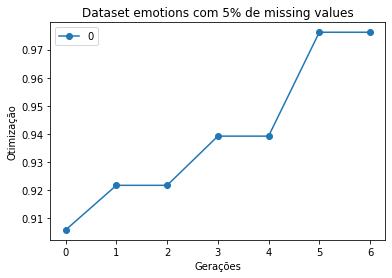

In [239]:
graph.plot(title='Dataset emotions com 5% de missing values',style='.-',marker='o',xlabel="Gerações", ylabel="Otimização")